In [1]:
import numpy as np 
from astropy.io import fits
from astropy.coordinates import SkyCoord  
import astropy.units as u
import matplotlib.pylab as plt 

# plt.rc('text', usetex=True) - Imperial cluster cannot find Latex
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
fits_image = fits.open('./data/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits')
data = fits_image[1].data

# Notes

Important columns identified in the catalogue. 

### Positions on the sky

- ALPHA_J2000 (deg)
- DELTA_J2000 (deg)

### Ellipticities and Weights
- e1
- e2 
- weight

### Flux 

- FLUX_GAAP_u (count)
- FLUX_GAAP_g (count)
- FLUX_GAAP_r (count)
- FLUX_GAAP_i (count)
- FLUX_GAAP_Z (count)
- FLUX_GAAP_Y (count)
- FLUX_GAAP_J (count)
- FLUX_GAAP_H (count)
- FLUX_GAAP_Ks (count)

### Flux Errors

- FLUXERR_GAAP_u  (count)
- FLUXERR_GAAP_g (count)
- FLUXERR_GAAP_r (count)
- FLUXERR_GAAP_i (count)
- FLUXERR_GAAP_Z (count)
- FLUXERR_GAAP_Y (count)
- FLUXERR_GAAP_J (count)
- FLUXERR_GAAP_H (count)
- FLUXERR_GAAP_Ks (count)

### Magnitude 

- MAG_GAAP_u (mag)
- MAG_GAAP_g (mag)
- MAG_GAAP_r (mag)
- MAG_GAAP_i (mag)
- MAG_GAAP_Z (mag)
- MAG_GAAP_Y (mag)
- MAG_GAAP_J (mag)
- MAG_GAAP_H (mag)
- MAG_GAAP_Ks (mag)

### Magnitude Error

- MAGERR_GAAP_u (mag) 
- MAGERR_GAAP_g (mag)
- MAGERR_GAAP_r (mag)
- MAGERR_GAAP_i (mag)
- MAGERR_GAAP_Z (mag)
- MAGERR_GAAP_Y (mag)
- MAGERR_GAAP_J (mag)
- MAGERR_GAAP_H (mag)
- MAGERR_GAAP_Ks (mag)

### Magnitude Limit

- MAG_LIM_u (mag)
- MAG_LIM_g (mag)
- MAG_LIM_r (mag)
- MAG_LIM_i (mag)
- MAG_LIM_Z (mag)
- MAG_LIM_Y (mag)
- MAG_LIM_J (mag)
- MAG_LIM_H (mag)
- MAG_LIM_Ks (mag)

### Flag (all of them 0)

- FLAG_GAAP_u
- FLAG_GAAP_g
- FLAG_GAAP_r
- FLAG_GAAP_i
- FLAG_GAAP_Z
- FLAG_GAAP_Y
- FLAG_GAAP_J
- FLAG_GAAP_H
- FLAG_GAAP_Ks

### BPZ

- M_0 (reference magnitude for BPZ prior)
- Z_B (9 band BPZ redshift estimate - peak of posterior)
- Z_ML (9 band BPZ maximum likelihood redshift)
- Z_B_MIN (lower bound of the 68% confidence interval of Z_B)
- Z_B_MAX (upper bound of the 68% confidence interval of Z_B)

# Plot Objects on the Sky

We have chosen the first 500 000 objects in the catalogue. Takes a long time to plot all the samples. 

In [3]:
xarr, yarr = data['ALPHA_J2000'], data['DELTA_J2000']
nobjects = 500000
eq = SkyCoord(xarr[0:nobjects], yarr[0:nobjects], unit=u.deg)
gal = eq.galactic
colors = np.random.random((nobjects, 3))

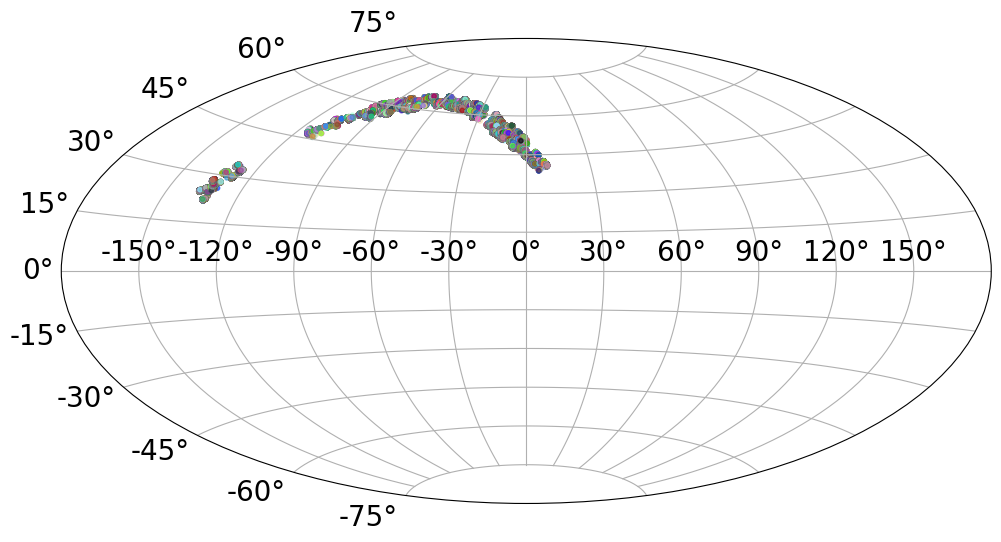

In [4]:
plt.figure(figsize = (12, 8))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=10, c=colors, alpha=0.6, edgecolors=colors, rasterized=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('plots/skymap.pdf', bbox_inches = 'tight')
plt.show()

## Plot bandpowers, covariance matrix and SOM redshift distributions

In [5]:
data = fits.open('./data/KiDS1000_cosmis_shear_data_release/data_fits/bp_KIDS1000_BlindC_with_m_bias_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid.fits')

In [30]:
covariance= data['COVMAT'].data

In [40]:
# cosmic shear data vector
data_vector_PeeE = data['PeeE'].data['VALUE']

# GGL data vector
data_vector_PneE =data['PneE'].data['VALUE']

In [52]:
redshift = data["nz_source"].data['Z_MID']
h1 = data["nz_source"].data['BIN1']
h2 = data["nz_source"].data['BIN2']
h3 = data["nz_source"].data['BIN3']
h4 = data["nz_source"].data['BIN4']
h5 = data["nz_source"].data['BIN5']

redshift = np.concatenate(([0], redshift))
h1 = np.concatenate(([0], h1))
h2 = np.concatenate(([0], h2))
h3 = np.concatenate(([0], h3))
h4 = np.concatenate(([0], h4))
h5 = np.concatenate(([0], h5))

In [53]:
n1 = h1 / np.trapz(h1, redshift)
n2 = h2 / np.trapz(h2, redshift)
n3 = h3 / np.trapz(h3, redshift)
n4 = h4 / np.trapz(h4, redshift)
n5 = h5 / np.trapz(h5, redshift)

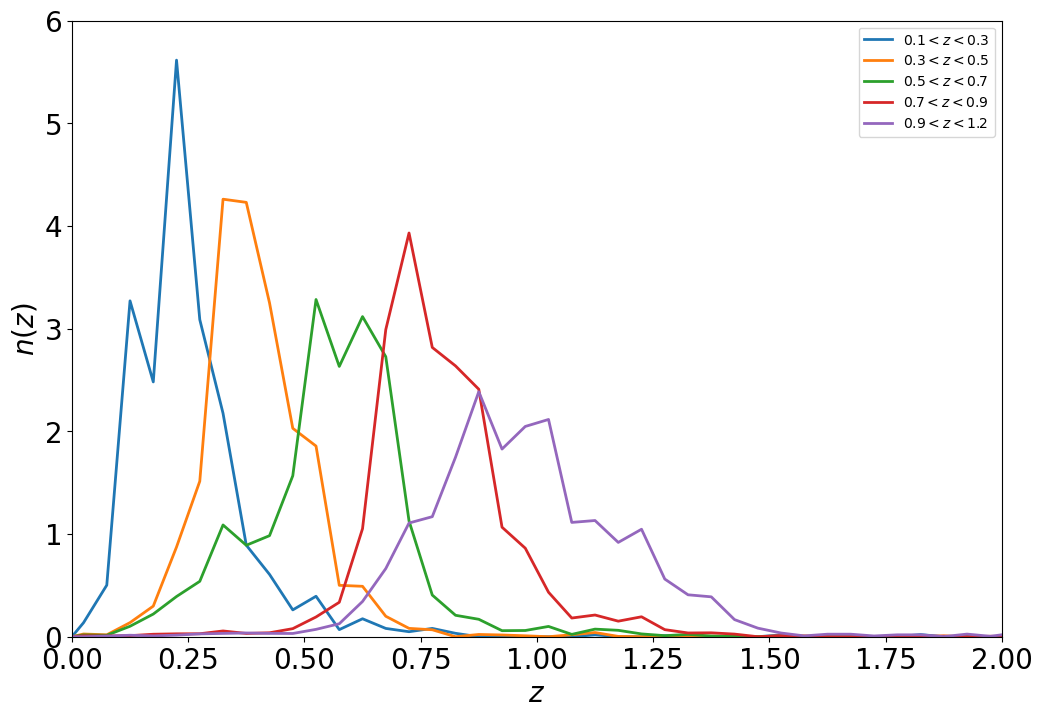

In [63]:
plt.figure(figsize = (12, 8))
plt.plot(redshift, n1, lw = 2, label = r'$0.1<z<0.3$')
plt.plot(redshift, n2, lw = 2, label = r'$0.3<z<0.5$')
plt.plot(redshift, n3, lw = 2, label = r'$0.5<z<0.7$')
plt.plot(redshift, n4, lw = 2, label = r'$0.7<z<0.9$')
plt.plot(redshift, n5, lw = 2, label = r'$0.9<z<1.2$')
plt.ylabel(r'$n(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.xlim(0.0, 2.0)
plt.ylim(0.0, 6.0)
plt.legend()
plt.show()

# Choosing Specific Columns

In [39]:
band = ['u', 'g', 'r', 'i', 'Z', 'Y', 'J', 'H', 'Ks']